In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import cv2
from sklearn.metrics import confusion_matrix,precision_score,recall_score

In [3]:
IMAGE_SIZE = 150
def generate_SSF_Array(img) -> np.ndarray:
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([20, 100, 200])
    upper_yellow = np.array([30, 255, 255])
    lower_orange = np.array([5, 50, 200])
    upper_orange = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv, lower_orange, upper_orange)
    mask2 = cv2.inRange(hsv, lower_yellow, upper_yellow)
    pixel_count1 = np.sum(mask1, axis=0)
    pixel_count2 = np.sum(mask2, axis=0)
    pixel_count = pixel_count1 + pixel_count2
    # Calculate the standard deviation of pixel_count values
    std_dev = np.std(pixel_count)
    # Detect sudden spikes in pixel_count values
    spike_indices = []
    fall_indices = []
    for i in range(len(pixel_count)):
        if pixel_count[i] > 100 and np.mean(pixel_count[i-2:i]) < 10:
            spike_indices.append(i)
        elif pixel_count[i] < 10 and np.mean(pixel_count[i-1:i]) > 100:
            fall_indices.append(i)
    return np.array([std_dev,len(spike_indices),len(fall_indices)])

In [4]:
flame_dir = "Flame_cropped/"
fire_dir = "Fire_full/"

def prep_img(file_path):
    IMG_SIZE = 150  # 50 in txt-based
    img_array = cv2.imread(file_path)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    via_array = generate_SSF_Array(new_array)
    return [new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3),np.array([via_array])]

In [5]:
flame_files = os.listdir(flame_dir)
fire_files = os.listdir(fire_dir)

model = load_model("64x2-CNN_impure_ssf.model")

In [6]:
y_pred = []
y_true = []
for filename in flame_files:
    img = prep_img(flame_dir + filename)
    prediction = model.predict(img)
    y_pred.append(int(prediction[0][1]))
    y_true.append(1)  # 1 represents "flame" class

for filename in fire_files:
    img = prep_img(fire_dir + filename)
    prediction = model.predict(img)
    y_pred.append(int(prediction[0][1]))
    y_true.append(0)  # 0 represents "fire" class

y_true = np.array(y_true)
y_pred = np.array(y_pred)

c:\Users\sagar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\sagar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[746   9]
 [148 334]]
Accuracy:  0.8730800323362975
Precision:  0.9737609329446064
Recall:  0.6929460580912863


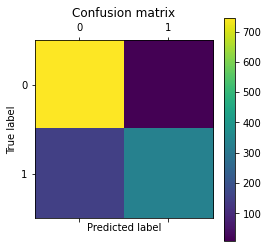

In [7]:
cm = confusion_matrix(y_true, y_pred)
print(cm)
print("Accuracy: ",(cm[0][0]+cm[1][1])/np.sum(cm))
print("Precision: ",precision_score(y_true, y_pred))
print("Recall: ",recall_score(y_true, y_pred))
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()